In [3]:
import torch
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

In [4]:
class block:
    def __init__(self, node_property,bosong,delta_t=1,noise_sigma = 0.02):#delta 为0.1-1
        # A block is a set of spiking neurals with inner full connections, we consider 4 connections:
        # AMPA, NMDA, GABAa and GABAb
        # shape note:
        #
        # N: numbers of neural cells
        # K: connections kind, = 4 (AMPA, NMDA, GABAa and GABAb)
     
        N = 1
        K = 4
        self.noise_sigma=noise_sigma
        self.bosong=bosong
        
        self.delta_t = delta_t

        self.I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
        self.V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
        self.tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]
        self.g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
        self.g_Li = torch.tensor(node_property[:, 6])  # shape [N]
        self.V_L = torch.tensor(node_property[:, 7])  # shape [N]
        self.C = torch.tensor(node_property[:, 4])   # shape [N]
        self.sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
        self.V_th = torch.tensor(node_property[:, 8])  # shape [N]
        self.V_reset = torch.tensor(node_property[:, 9]) # shape [N]
        self.T_ref = torch.tensor(node_property[:, 5]) # shape [N]

        self.t_ik_last = torch.zeros([N]) # shape [N]
        self.V_i = torch.ones([N]) * (self.V_th + self.V_reset)/2  # membrane potential, shape: [N]
        self.J_ui = torch.zeros([K, N])  # shape [K, N]
        ###问题：J_ui的初值是否有特殊要求？
        self.t = torch.tensor(0.)  # scalar

        self.update_I_syn()


    def update_J_ui(self, delta_t):
        # active shape: [N], dtype bool
        # t is a scalar
        g=np.array(self.t)
        self.J_ui = self.J_ui * torch.exp(-delta_t / self.tau_ui) #shape:4*1
        bosong1= self.bosong[:,int(g)]#产生01的泊松分布
        J_ui_activate_part = torch.tensor(bosong1).view(4,1) # !!! this part can be sparse.#####输入一个泊松分布
        self.J_ui += J_ui_activate_part
        pass


    def update_I_syn(self):
        self.I_ui = self.g_ui * (self.V_ui - self.V_i) * self.J_ui
        # [K, N]            [K, N] - [K, 1]
        self.I_syn = self.I_ui.sum(dim=0)
        pass

    def update_Vi(self, delta_t):
        main_part = -self.g_Li * (self.V_i - self.V_L)
        C_diff_Vi = main_part + self.I_syn + self.I_extern_Input#I_extern_Input为外部刺激
        delta_Vi = delta_t / self.C * C_diff_Vi

        Vi_normal = self.V_i + delta_Vi

        is_not_saturated = (self.t >= self.t_ik_last + self.T_ref)#判断是否放处于静息期
        V_i = torch.where(is_not_saturated, Vi_normal, self.V_reset)#将处在静息期的设置为静息状态
        #print(is_not_saturated.sum())
        active = (V_i >= self.V_th)#判断是否超过阈值，放电
        self.V_i = torch.min(V_i, self.V_th)+np.random.normal(0,self.noise_sigma**2)
        return active

    def update_t_ik_last(self, active):
        self.t_ik_last = torch.where(active, self.t, self.t_ik_last)#如果激发了，就把t_ik_last设为此时刻

    def run(self, noise_rate=0.01, isolated=False):
        self.t += self.delta_t #更新时间
        self.active = self.update_Vi(self.delta_t)#处于激活/不激活
        
        self.update_J_ui(self.delta_t)
        self.update_I_syn()
        self.update_t_ik_last(self.active)

#         mean_Vi = []
#         sum_activate = []
#         for i in range(self.sub_idx.max().int() + 1):
#             mean_Vi.append(self.V_i[self.sub_idx == i].mean())
#             sum_activate.append(self.active[self.sub_idx == i].float().sum())
        return self.V_i,self.t#输出电压变化和时间

#         return torch.stack(sum_activate), torch.stack(mean_Vi)



In [5]:
def generate_property(C=1,T_ref=5,g_Li=0.001,V_Ls=-75,V_th=-50,V_reset=-65,\
                      g_ui =np.array([10/500, 5/6000, 3/60, 1/1000]),V_ui = np.array([0, 0, -70, -100]),\
                     tao_ui =np.array ([2, 40, 10, 50])):
    # each node contain such property:
    #          E/I, blocked_in_stat, I_extern_Input, sub_block_idx, C, T_ref, g_Li, V_L, V_th, V_reset, g_ui, V_ui, tao_ui
    #   size:  1,   1,               1,                1,           1, 1,     1,    1,   1,    1,       4     4,    4
    #   dtype: b,   b,               f,                i,           f, f,     f,    f,   f,    f,       f,    f,    f
    # b means bool(although storage as float), f means float.

    property = np.zeros([1, 22], dtype=np.float32)
    E_thresh = 1
    property[:, 0] = 1
    property[:, 1] = 0 
    property[:, 2] = 0
    property[:, 3] = 0
    
    property[:, 4] = C #膜电容，一般1
    property[:, 5] = T_ref #不应期，1-10，原来为5
    property[:, 6] = g_Li #渗流突触导电率 一般为0.03
    property[:, 7] = V_Ls #渗流电位 一般为-75
    property[:, 8] = V_th #发放阈值电位 一般为-50
    property[:, 9] = V_reset #重置电位 一般为-65

#   g_ui =np.array([5/275, 5/4000, 3/30, 3/730])
#   g_ui =np.array([10/825, 5/6000, 3/60, 3/1460])
    g_ui =g_ui if isinstance(g_ui, np.ndarray) else np.array(g_ui)
    property[:, 10:14] = g_ui
    
    V_ui =  V_ui  if isinstance(V_ui, np.ndarray) else np.array(V_ui)#ui的电位
    property[:, 14:18] = V_ui
    
#     tao_ui =np.array ([1, 20, 5, 25])
    tao_ui = tao_ui if isinstance(tao_ui, np.ndarray) else np.array(tao_ui)

    property[:, 18:22] = tao_ui

    return property


In [6]:
#突触导电率比例
torch.manual_seed(2020)
#Sets the seed for generating random numbers. Returns a 'torch.Generator' object.
ranadj=torch.rand(10,2)#之后会产生十个泊松输入，按照ranadj的比例传输给神经元,随机的权重
#ranadj/=350
print(ranadj)

tensor([[0.4869, 0.1052],
        [0.5883, 0.1161],
        [0.4949, 0.2824],
        [0.5899, 0.8105],
        [0.2512, 0.6307],
        [0.5403, 0.8033],
        [0.7781, 0.4966],
        [0.8888, 0.5570],
        [0.7127, 0.0339],
        [0.1151, 0.8780]])


In [7]:
with open('ranadj.pickle','wb') as f:
    pickle.dump(ranadj,f)#储存为pickle.dump

In [8]:
nums = 10
T_size = 20000
scale=T_size*nums+1
A=np.zeros([4,scale])
for num in range(nums):
    #Aj是激活标志位，A的第一个轴表示ui，第二个是时间刻度
    bos=np.random.exponential(30,T_size//2).astype(np.int16).reshape(10,-1)
    bosA=np.zeros([10,T_size+1])

    for k in range(10):
        j=0
        i=bos[k][j]
        while i<T_size+1:
            bosA[k][i]=1
            j=j+1
            i=i+bos[k][j]
            #print(j)
    print(num)
    for p in range(T_size):
        A[0,p+T_size*num]=sum(bosA[:7,p]*(ranadj[:7,0].numpy()))
        A[1,p+T_size*num]=sum(bosA[:7,p]*(ranadj[:7,1].numpy()))
        A[2,p+T_size*num]=bosA[8,p]*ranadj[8,0]+bosA[9,p]*ranadj[9,0]
        A[3,p+T_size*num]=bosA[8,p]*ranadj[8,1]+bosA[9,p]*ranadj[9,1]

0
1
2
3
4
5
6
7
8
9


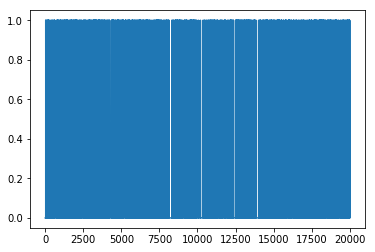

In [9]:
plt.plot(bosA[1,:])

In [10]:
with open('Abos.pickle','wb') as f:
    pickle.dump(A,f)

In [11]:
node_property=generate_property()
with open('node_property.pickle','wb') as f:
    pickle.dump(node_property,f)#储存为pickle.dump

In [12]:
def main():
    x_out=[]
    y_out=np.zeros(T_size*nums)
    b=block(node_property,A,delta_t=1)
    for i in range(T_size*nums):
        x,y=b.run()
#         print("x:",x)
#         print("y:",y)
        x_out.append(x)
        y=np.array(y)
        y_out[i]=y
    return x_out,y_out

In [13]:
if __name__=="__main__":
    yy,tt1=main()

In [14]:
yy1=np.array(yy)
tt1=np.array(tt1)

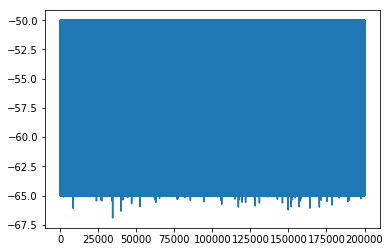

In [15]:
plt.plot(tt1,yy1)
plt.show()

In [16]:
len(yy1[yy1==-50])/(T_size*nums/1000)#spike的频率（hz）

0.06

In [17]:
yy1.min()#最低电压

-66.908714

In [18]:
results = [tt1, yy1]
with open('small_cell_500ms_noise.pickle','wb') as f:
    pickle.dump(results,f)